# Data challenge - week 7

## Costly Conversion

Set up: <br>
Working for Symantec <br>
Unfortunately, revenue has flattened out <br>
The team has run an AB test to see if increasing the price of the product might be a good move to increase revenue <br> <br>
In the experiment, 2/3 of users were offered the original price 39 <br>
While 1/3 were presented with a new price of 59

In this test we would like to look at conversion being the user bought the software or not. i.e, converting from visitor to customer.

Requested deliverable: <br>
How did the experiment go? <br>
Recommendation of what price should the product be sold at? <br>
Quantification of how much the experiment cost the company <br>
Should the expeirment have been run for a shorter time? <br>
Could the experiment have been designed differently? <br>

----

## Plan

### Initial EDA
There are some things that come to mind that we should look out for during our exploration before we begin modeling and providing recommendations: <br>
There may be a class imbalance in the data sets. While the selection of 2/3 and 1/3 are not a massive difference there could be unexpected correlations in groups that may affect our models. So we should look at the distributions of each group individually. <br>

### Quantify performance
Compare performance of conversion between groups

### Recommend price
See which condition performed better, <br>
Recommend that price for now

### Cost of experiment
Random forest model for if a user would convert if price was kept low.<br> How much would have been made compared to how much was made...

### Experiment time
Test if experiment could have been informative using less data based on time

------

# Load and clean data

In [142]:
# Import initial packages
# Other packages will be loaded as needed but are listed here
import numpy as np
import pandas as pd

# matplotlib.pyplot

In [143]:
# Load data
dir_name = '/Users/mbeckert/Documents/code/insight_testing/data_challenges/week7/'

user_df = pd.read_csv(dir_name + 'user_table.csv')
test_df = pd.read_csv(dir_name + 'test_results.csv')

In [144]:
print(user_df.keys() )
print(test_df.keys() )

Index(['user_id', 'city', 'country', 'lat', 'long'], dtype='object')
Index(['Unnamed: 0', 'user_id', 'timestamp', 'source', 'device',
       'operative_system', 'test', 'price', 'converted'],
      dtype='object')


In [145]:
# Let's merge the data sets now 
conv_df = pd.merge(user_df, test_df, on='user_id')
print(len(conv_df) == len(user_df))
del user_df, test_df # And we can keep our workspace clean

True


In [146]:
# All users are located in the USA, so we will drop this column
# New data sets may be able to use this column if there is some different countries for visitors
conv_df = conv_df.drop(columns='country')

# Additionally, there seems to be an issue with loading in the test_df
# So the index gets placed in a new unnamed column, so we can remove it 

conv_df = conv_df.drop(columns='Unnamed: 0')

In [147]:
# Check and drop any duplicates
conv_df = conv_df.drop_duplicates()

# Note that there were no apparent dupes here

# Confirming unique entries
print(len(conv_df['user_id'].unique()) == len(conv_df))

True


In [148]:
# Also check if there are missing values
print(len(conv_df[conv_df.isnull().any(axis=1)]))
print(len(conv_df[conv_df.isnull().any(axis=1)]) /
      len(conv_df))

18318
0.06646203413444793


In [149]:
print(conv_df[conv_df.isnull().any(axis=1)])

        user_id              city    lat    long            timestamp  \
13       764610        Chesapeake  36.68  -76.31  2015-04-26 08:24:27   
15       765240           Seattle  47.62 -122.35  2015-03-23 06:04:05   
30       548203        Birmingham  33.53  -86.80  2015-05-08 16:24:23   
96       885183          New York  40.67  -73.94  2015-04-24 01:25:43   
100      402771      North Bergen  40.79  -74.03  2015-05-08 08:40:35   
129      859684        Cedar Hill  32.58  -96.96  2015-03-07 10:36:15   
130      669169           Houston  29.77  -95.39  2015-05-29 18:30:10   
132      793256         Fairfield  39.33  -84.54  2015-03-13 09:54:36   
154      949539   Highlands Ranch  39.55 -104.97  2015-03-15 11:01:57   
160      655823      Jacksonville  30.33  -81.66  2015-03-21 15:06:32   
178      355895          Columbus  32.51  -84.87  2015-04-07 19:35:34   
215      254956            Fresno  36.78 -119.79  2015-03-27 19:54:22   
247      326947          San Jose  37.30 -121.85  2

In [150]:
print(len(conv_df[conv_df.isnull().any(axis=1)]))
print(len(conv_df[conv_df['operative_system'].isnull()]))

18318
17777


There are about 7% of the rows missing values <br>
But most of them are restricted to the "operative system" column <br>
It is likely an interesting question if OS makes a difference, <br>
So we will keep the column and just remove the nan rows.

In [151]:
conv_df = conv_df.dropna()

In [152]:
# Make sure the data frame columns' dtype match what we expect
conv_df.dtypes

user_id               int64
city                 object
lat                 float64
long                float64
timestamp            object
source               object
device               object
operative_system     object
test                  int64
price               float64
converted             int64
dtype: object

Looks like the dtypes makes sense <br>
Next let's check for strange values in each column

In [153]:
print(conv_df['city'].unique())

['Peabody' 'Reno' 'Rialto' 'Carson City' 'Chicago' 'New York' 'Durham'
 'Burke' 'Oklahoma City' 'Charlotte' 'Brentwood' 'Oakland' 'Stratford'
 'Topeka' 'Fort Lauderdale' 'Newport News' 'Kansas City' 'Amarillo'
 'Lawton' 'Houston' 'Casas Adobes' 'Bridgeport' 'Memphis' 'Quincy'
 'Los Angeles' 'Federal Way' 'Rancho Cucamonga' 'Fontana' 'Cuyahoga Falls'
 'Gilbert' 'Redford' 'Shreveport' 'Indianapolis' 'Austin' 'Hesperia'
 'Meriden' 'Toms River' 'Chicopee' 'Spring Hill' 'Dearborn' 'Jacksonville'
 'Avondale' 'La Habra' 'Toledo' 'Temple' 'Colton' 'San Antonio'
 'Eau Claire' 'Union City' 'Redondo Beach' 'Mesa' 'Overland Park' 'Revere'
 'Wellington' 'Citrus Heights' 'Fort Smith' 'Yonkers' 'Cary' 'Fullerton'
 'Woonsocket' 'Southfield' 'Nashville' 'North Fort Myers' 'Metairie'
 'Florissant' 'Germantown' 'Birmingham' 'Seattle' 'Provo'
 'Augusta-Richmond' 'Henderson' 'Dublin' 'Louisville' 'Janesville'
 'Conway' 'DeSoto' 'Pinellas Park' 'Milwaukee' 'Portsmouth' 'Chula Vista'
 'Tulsa' 'Arlington' 'Bo

In [154]:
# Lots of cities. We could try and use them discretely, but we do have the lat-longs
# Those boil down to continuous variables, so we can drop cities here
conv_df = conv_df.drop(columns='city')

In [155]:
print(conv_df['source'].unique())
# Looks fine, but need to decide how to represent them
# There are not too many of them, so one-hot encoding sounds viable

['ads-google' 'ads_facebook' 'direct_traffic' 'ads_other' 'seo-google'
 'ads-bing' 'friend_referral' 'seo-other' 'seo_facebook' 'seo-bing'
 'seo-yahoo' 'ads-yahoo']


In [156]:
print(conv_df['device'].unique())
# Looks fine, also we can nicely convert this to a binary later

['mobile' 'web']


In [157]:
print(conv_df['operative_system'].unique())

['android' 'windows' 'iOS' 'mac' 'wnddows' 'i0S' 'anroid' 'apple']


In [159]:
# Some typos, and we can change apple to iOS too, let's fix them here

In [160]:
conv_df = conv_df.replace('wnddows', 'windows')
conv_df = conv_df.replace('anroid', 'android')
conv_df = conv_df.replace(['i0S', 'apple', 'mac'], 'iOS')
print(conv_df['operative_system'].unique())

# Looks fine now.
# We will be able to one-hot encode these as well

['android' 'windows' 'iOS']


In [161]:
print(conv_df['test'].unique())
# Looks fine

[0 1]


In [162]:
print(conv_df['price'].unique())
# problem here, 
# but luckily the 'test' column tells us what price they should have
# So we can drop this row for now and look into that later
conv_df = conv_df.drop(columns='price')

[3.90000000e+01 5.90000000e+01 3.68124040e+08 ... 8.68708668e+08
 6.32620159e+08 3.28710782e+08]


In [163]:
print(conv_df['converted'].unique())
# Looks good

[0 1]


In [164]:
# Now we need to convert the time stamps to a datetime
from datetime import datetime

# For simplicity we will omit the hours, minutes, and seconds.
# There are errors in some of those entries and going through linearly is very time consuming

conv_df['timestamp'] = conv_df['timestamp'].apply(lambda x: datetime.strptime(x[0:10], '%Y-%m-%d').date())


# Note that we are ignoring time zones here, 
# but shifting a couple hours is likely not going to affect things majorly at this level
# We could use the city location to determine time zone and convert to date-time if we really wanted to

In [165]:
# Error with one entry.
print(str(min(conv_df['timestamp'])) + ' - ' + str(max(conv_df['timestamp'])))

2015-03-02 - 2815-05-31


In [166]:
# Just drop the large error values
from datetime import date
conv_df['timestamp'].loc[conv_df['timestamp'] > date(2020, 1, 1)] = np.nan
conv_df = conv_df.dropna()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [167]:
print(len(conv_df))
print(str(min(conv_df['timestamp'])) + ' - ' + str(max(conv_df['timestamp'])))
# Date range looks okay

257047
2015-03-02 - 2015-05-31


## Exploratory plots

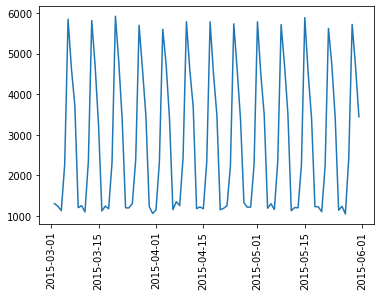

In [168]:
# Is there any fluctuations in activity across dates?
import matplotlib.pyplot as plt
tmp = conv_df['timestamp'].groupby([conv_df['timestamp']]).count()
plt.plot(tmp)
plt.xticks(rotation=90)
plt.show()

Looks like we have some periodicity <br>
Perhaps this is related to day of the week

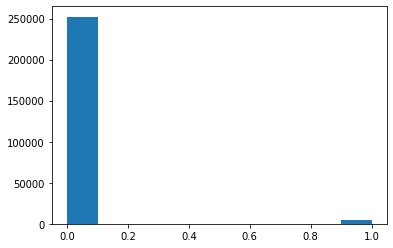

0.019057247066286077


In [169]:
# Check for class imbalance
plt.hist(conv_df['converted'])
plt.show()
print(len(conv_df['converted'].loc[conv_df['converted'] == 1.0]) / len(conv_df['converted'].loc[conv_df['converted'] == 0.0]))

We have a major class imbalance in how many people in general convert.
No matter what model we use we will need to check balance our training set

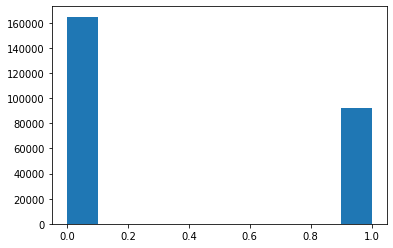

0.559931060012987


In [170]:
# Check for class imbalance
plt.hist(conv_df['test'])
plt.show()
print(len(conv_df['test'].loc[conv_df['test'] == 1.0]) / len(conv_df['test'].loc[conv_df['test'] == 0.0]))

Interestingly the split in test and control group is not quite 1/3 and 2/3, <br>
But they are pretty close

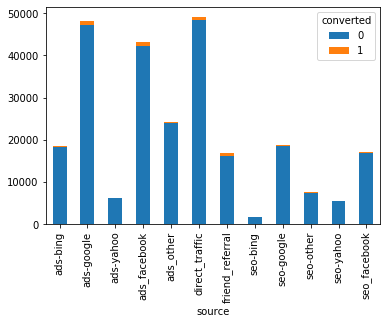

In [171]:
tmp = conv_df.groupby(['source','converted']).count()['user_id']
tmp.unstack().plot(kind='bar', stacked=True)

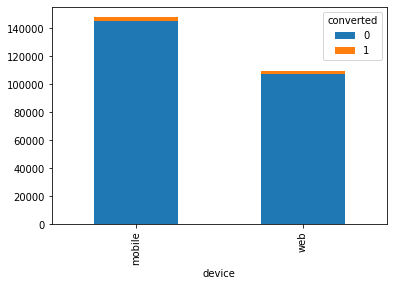

In [172]:
tmp = conv_df.groupby(['device','converted']).count()['user_id']
tmp.unstack().plot(kind='bar', stacked=True)

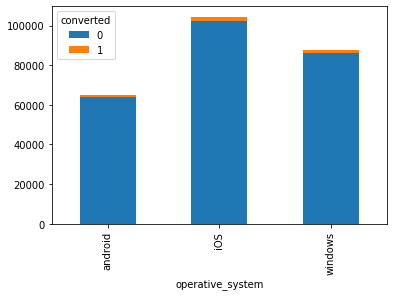

In [173]:
tmp = conv_df.groupby(['operative_system','converted']).count()['user_id']
tmp.unstack().plot(kind='bar', stacked=True)

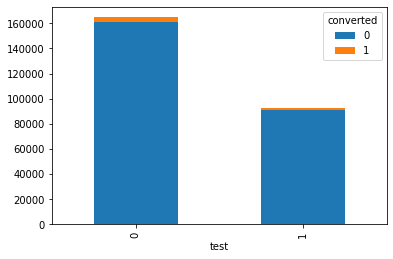

In [174]:
tmp = conv_df.groupby(['test','converted']).count()['user_id']
tmp.unstack().plot(kind='bar', stacked=True)

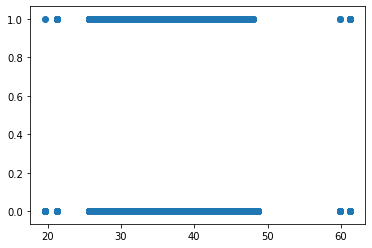

In [175]:
plt.scatter(conv_df['lat'], conv_df['converted'])
plt.show()

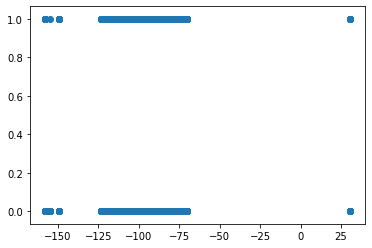

In [176]:
plt.scatter(conv_df['long'], conv_df['converted'])
plt.show()

# How did the experiment do?

Simple analysis if there is a difference in the percentage of people converting in test or control

In [177]:
total_test = len(conv_df['test'].loc[conv_df['test'] == 1.0])
total_control = len(conv_df['test'].loc[conv_df['test'] == 0.0])

test = conv_df['converted'].loc[conv_df['test'] == 1.0]
control = conv_df['converted'].loc[conv_df['test'] == 0.0]

per_test_conv = len(test.loc[test == 1.0]) / total_test
per_cont_conv = len(test.loc[control == 1.0]) / total_control

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [ ]:
plt.bar(['per_test_conv', 'per_cont_conv'], [per_test_conv, per_cont_conv])
plt.show()

# Classifier for conversion

We will train 2 models, <br>
One for the test group and the other for the control

We can then make predictions on whether the test would have generated more revenue or not

## Some pre-processing
One-hot encoder <br>
Scaling <br>
Class balancing <br>

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


def pre_process(features, y):
    features = pd.get_dummies(features)
    scaler = MinMaxScaler()
    try:
        features[['lat', 'long']] = scaler.fit_transform(features[['lat', 'long']])
    except:
        print('no lat/long')
        
    X_train, X_test, y_train, y_test = train_test_split(
        features, y, test_size = 0.2, random_state = 0)

    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    feat_key = features.keys()
    return X_resampled, y_resampled, X_test, y_test, feat_key

In [58]:
conv_df = conv_df.replace('web', 0)
conv_df = conv_df.replace('mobile', 1)

conv_test = conv_df.loc[conv_df['test'] == 1]
conv_cont = conv_df.loc[conv_df['test'] == 0]

feat_cont = conv_cont[['lat', 'long', 'source', 'device', 'operative_system']]
y_cont = conv_cont['converted']

feat_exp = conv_test[['lat', 'long', 'source', 'device', 'operative_system']]
y_exp = conv_test['converted']

## Modeling (Decision Tree)

In [37]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn
from sklearn.metrics import confusion_matrix

def Decision_Tree(features, y):
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 0,
                               max_depth=10, min_samples_leaf=5)

    X_resampled, y_resampled, X_test, y_test, feat_key = pre_process(features, y)
    
    clf_gini.fit(X_resampled, y_resampled);
    
    predictions = clf_gini.predict(X_test)

    # Plot a confusion matrix of our performance
    df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), 
    index = ['no-conversion', 'convert'], 
    columns = ['no-conversion', 'convert'])

    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True)
    
    return clf_gini

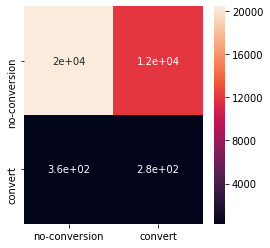

In [41]:
clf_cont = Decision_Tree(feat_cont, y_cont)

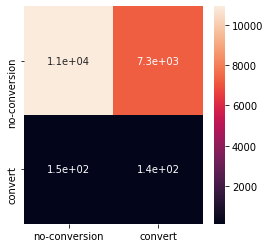

In [43]:
clf_test = Decision_Tree(feat_exp, y_exp)

## Model (Random Forest Classifier)

In [87]:
from sklearn.ensemble import RandomForestClassifier

def Random_forest(features, y):
    clf=RandomForestClassifier(n_estimators=100)

    X_resampled, y_resampled, X_test, y_test, feat_key = pre_process(features, y)
    
    clf.fit(X_resampled, y_resampled);
    
    predictions = clf.predict(X_test)

    # Plot a confusion matrix of our performance
    df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), 
    index = ['no-conversion', 'convert'], 
    columns = ['no-conversion', 'convert'])

    plt.figure(figsize = (4,4))
    sn.heatmap(df_cm, annot=True)
    plt.show()
    
    feature_imp = pd.Series(clf.feature_importances_, index=feat_key).sort_values(ascending=False)
    print(feature_imp)

    %matplotlib inline
    # Creating a bar plot
    sn.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()

    return clf, predictions

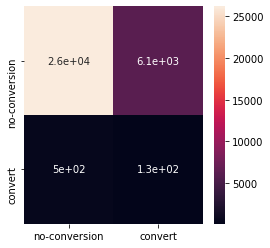

No handles with labels found to put in legend.


long                        0.456317
lat                         0.452156
source_friend_referral      0.020232
source_direct_traffic       0.011034
operative_system_iOS        0.007804
device                      0.006244
operative_system_android    0.005852
source_ads_facebook         0.005244
source_ads-bing             0.005093
source_ads-google           0.005029
source_ads_other            0.004167
source_seo-google           0.003739
source_seo_facebook         0.003580
source_seo-other            0.003385
source_seo-yahoo            0.002729
source_ads-yahoo            0.002697
operative_system_windows    0.002409
source_seo-bing             0.002288
dtype: float64


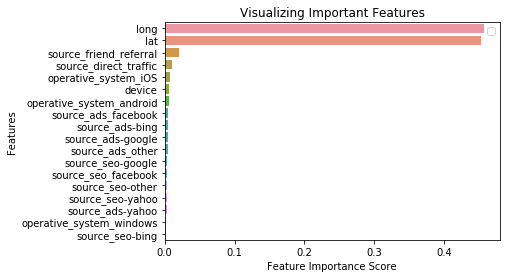

In [88]:
clf_cont, pred_cont = Random_forest(feat_cont, y_cont)

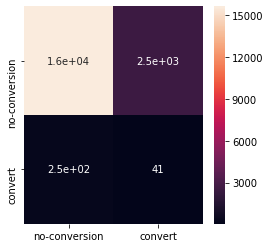

No handles with labels found to put in legend.


long                        0.461046
lat                         0.445019
source_friend_referral      0.017242
source_direct_traffic       0.011776
operative_system_iOS        0.009902
source_ads-google           0.007379
device                      0.007258
source_ads-bing             0.005210
source_ads_facebook         0.005201
operative_system_android    0.004378
source_ads_other            0.004064
source_seo-google           0.003737
source_seo_facebook         0.003519
source_seo-other            0.003505
source_seo-yahoo            0.003488
operative_system_windows    0.003391
source_ads-yahoo            0.002442
source_seo-bing             0.001444
dtype: float64


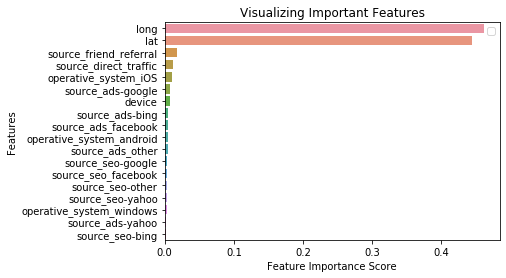

In [89]:
clf_test, pred_test = Random_forest(feat_exp, y_exp)

## Model performance without Lat/long
Lat and long are providing a surprising amount of importance <br>
This is surprising considering it did not look like they partitioned the data well by eye in the exploratory plotting phase <br>
Let's just see what the model looks like without them.

no lat/long


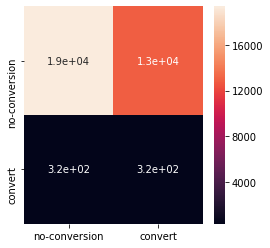

No handles with labels found to put in legend.


source_friend_referral      0.301679
source_direct_traffic       0.149916
operative_system_iOS        0.131662
operative_system_android    0.064762
source_ads_facebook         0.063049
source_ads-bing             0.052960
source_ads-google           0.045876
source_ads_other            0.035181
device                      0.030014
operative_system_windows    0.025119
source_seo-yahoo            0.019964
source_seo-other            0.019374
source_seo-bing             0.017527
source_seo_facebook         0.016704
source_seo-google           0.014731
source_ads-yahoo            0.011481
dtype: float64


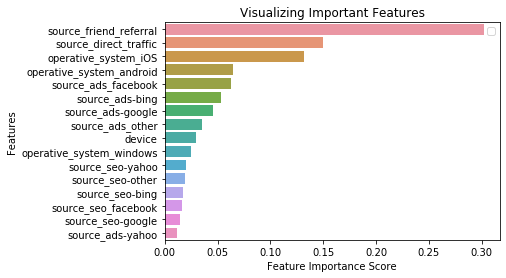

In [90]:
clf_cont_noLL, pred_cont_noLL = Random_forest(feat_cont.drop(columns=['lat', 'long']), y_cont)

no lat/long


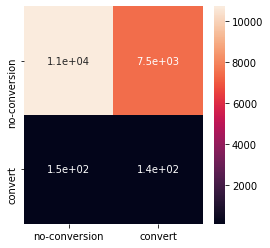

No handles with labels found to put in legend.


source_friend_referral      0.256402
source_direct_traffic       0.161573
operative_system_iOS        0.126704
source_ads-google           0.081443
source_ads-bing             0.061303
operative_system_android    0.056813
operative_system_windows    0.043322
source_ads_facebook         0.042929
source_seo-yahoo            0.033023
source_ads_other            0.031638
device                      0.031498
source_seo-other            0.028991
source_seo-google           0.020044
source_seo_facebook         0.014039
source_ads-yahoo            0.007523
source_seo-bing             0.002754
dtype: float64


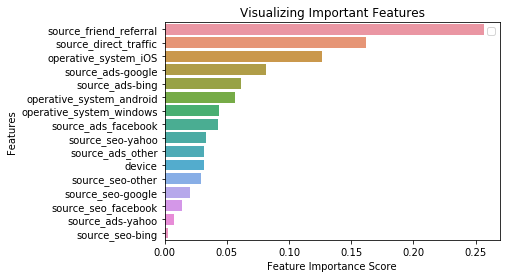

In [91]:
clf_test_noLL, pred_test_noLL = Random_forest(feat_exp.drop(columns=['lat', 'long']), y_exp)

# How much did Symantec make during the experiment
And how much could they have made using one or the other strategy

In [129]:
def Random_forest_crosspred(feat_1, y_1, feat_2, y_2):
    clf=RandomForestClassifier(n_estimators=100)

    X_resampled_1, y_resampled_1, X_test_1, y_test_1, feat_key = pre_process(feat_1, y_1)
    X_resampled_2, y_resampled_2, X_test_2, y_test_2, feat_key = pre_process(feat_1, y_1)
    
    clf.fit(X_resampled_1, y_resampled_1);
    
    predictions = clf.predict(X_test_2)

    return clf, predictions

In [130]:
test = conv_df['converted'].loc[conv_df['test'] == 1.0]
control = conv_df['converted'].loc[conv_df['test'] == 1.0]

made_test = len(test.loc[test == 1.0]) * 59
made_cont = len(test.loc[control == 1.0]) * 39

made_total = made_test + made_cont
print(made_total)

144844


In [131]:
clf, pred_cont = Random_forest_crosspred(feat_cont, y_cont, feat_exp, y_exp)
clf, pred_test = Random_forest_crosspred(feat_exp, y_exp, feat_cont, y_cont)

In [132]:
made_test_pred = sum(pred_cont) * 59 + made_test
made_cont_pred = sum(pred_test) * 39 + made_cont

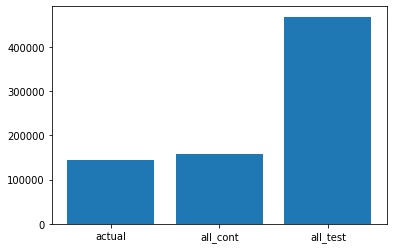

In [133]:
plt.bar(['actual', 'all_cont', 'all_test'], [made_total, made_cont_pred, made_test_pred])
plt.show()

Looks like if Symantec had switched to the higher price the entire time we could have made a lot more revenue <br>
Is there a time when we should have switched? <br>
Rather than waiting for 3 months?

# When should we have ended the experiment?

In [120]:
# How long did Symantec run this trial?
print(min(conv_df['timestamp'].unique()))
print(max(conv_df['timestamp'].unique()))

# 3 months

2015-03-02
2015-05-31


Let's run through all of the same steps that we did to identify potential profit for the total time the experiment was run. <br>
But this time let's look at the performance we can glean on a daily basis. <br>
We will need to look into the cyclic nature of activity as we saw in the EDA

We need to select a metric for this analysis. <br>
Considering the class, imbalance this is a non-trivial decision <br>
Overall accuracy will not do! <br>

The overall goal of the project would be to try and identify if the change in pricing is gaining traction <br>
It is likely more important to be conservative in this estimate though. <br>
We would never want to make a massive change with very little evidence. <br>

We should monitor the false positives in this case.

In [121]:
def assess_performance_time(features, y):
    clf=RandomForestClassifier(n_estimators=100)

    X_resampled, y_resampled, X_test, y_test, feat_key = pre_process(features, y)
    
    clf.fit(X_resampled, y_resampled);
    
    predictions = clf.predict(X_test)

    # Plot a confusion matrix of our performance
    cm = confusion_matrix(y_test, predictions)
    false_pos = cm[0,1] / (cm[0,1]+cm[0,0])
    false_neg = cm[1,0] / (cm[1,0]+cm[1,1])

    return false_pos, false_neg

This is where we would implement the analysis looking at performance across time! <br>
However, in the spirit of the "Data Challenge" format, <br>
I will leave you with my plans for the execution, as I am already over the allotted time...

# Future Plans

The next step for this project would be to run the model sequentially incorporating new data with each day. <br>
I would monitor the false positive rate, as I wish to be conservative in my estimation of how well the change in price would influence the revenue on the company. <br>
Finally, I would hopefully identify a shallowing in which we may wish to switch to the new price

Importantly about strategic plannning: <br>
I feel like the inital premise of the problem is malformed, as changing price in an AB testing condition is conventionally very dangerous. <br>

However, we might be able to improve upon it if we were hard pressed to implement. <br>
Continual monitoring is likely an important aspect, and weighting the distribution of "test" and "control" based upon performance could be interesting. So long as we try to achieve balance. <br>

# Conclusion

In this instance my deliverable is the preliminary findings regarding the experiment performance and the potential venue gain. In the form of a presentation (scheduled tomorrow) <br>
Future work would strongly try and identify markets for Symantec, opposed to a broad price change. <br>
Might certain prices be more appealing to specific users? <br>
What about where they live? This was a surprising feature in my models and I would really like to deep-dive into this particular feature<br>